# Assignment02: CLIP

## Basic Imports

In [1]:
import os
import io
import time
import os.path as osp

%matplotlib inline   
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from torchvision.datasets import CIFAR10
from torchvision import datasets
from torchvision import transforms, models
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from transformers import BertModel, BertTokenizer
import torchvision

from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from PIL import Image
from clip import clip

import pickle
from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Hyperparameters

In [2]:
# # random seed
# SEED = 1 
# NUM_CLASS = 10

# Training
BATCH_SIZE = 128
# NUM_EPOCHS = 30
# EVAL_INTERVAL=1
# SAVE_DIR = './log'

# # Optimizer
# LEARNING_RATE = 1e-1
# MOMENTUM = 0.9
# STEP=5
# GAMMA=0.5

## Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## Dataset


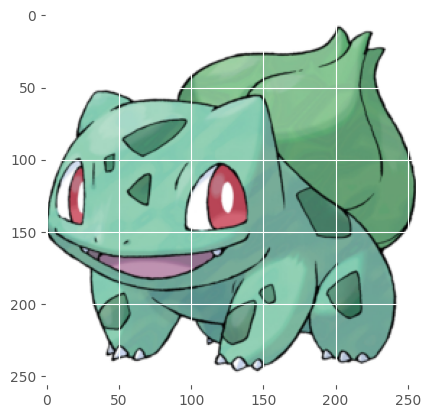

In [4]:
# Load preprocessed_data from the saved file
with open('data/preprocessed_data.pkl', 'rb') as file:
    loaded_data = pickle.load(file)
plt.imshow(loaded_data[0][0])

In [5]:
# Create dataset and DataLoader
class CustomDataset(Dataset):
    def __init__(self, data,transform = None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx][0]  
        text = self.data[idx][1]   
        if self.transform:    
            image = self.transform(image)    
        return image, text  

transform_clip = Compose([
    Resize((224, 224)),
    CenterCrop(224),
    ToTensor(),
    Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
              std=[0.26862954, 0.26130258, 0.27577711])
])

transform_bl = Compose([
    Resize((256, 256)),
    CenterCrop(256),
    ToTensor(),
    Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
              std=[0.26862954, 0.26130258, 0.27577711])
])

In [6]:
# # Set random seeds for reproducibility
# seed = 42
# torch.manual_seed(seed)
# np.random.seed(42)
# torch.cuda.manual_seed(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

In [7]:
# Create dataset and DataLoader using loaded_data
dataset_clip = CustomDataset(loaded_data,transform = transform_clip)
dataloader_clip = DataLoader(dataset_clip, batch_size=BATCH_SIZE, shuffle=False)

dataset_bl = CustomDataset(loaded_data,transform = transform_bl)
dataloader_bl = DataLoader(dataset_bl, batch_size=BATCH_SIZE, shuffle=False)

## Model

#### clip

In [8]:
print(clip.available_models())

# Load the model
VISUAL_BACKBONE = 'ViT-B/16' # RN50, ViT-B/32, ViT-B/16

model_clip, preprocess_clip = clip.load(name=VISUAL_BACKBONE, device=device, download_root='/shareddata/clip/')
model_clip.to(device);

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


#### baseline model

In [9]:
import torch.nn.functional as F

# Function to project text features to match image features dimensionality
class TextProjection(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(TextProjection, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)


# Instantiate the projection layer
projection_layer = TextProjection(input_dim=768, output_dim=1000).to(device)

In [10]:
# Load pre-trained BERT model and tokenizer for text encoding
text_encoder_bl = BertModel.from_pretrained('baselinemodel/bert-base-uncased')
tokenizer_bl = BertTokenizer.from_pretrained('baselinemodel/bert-base-uncased')
text_encoder_bl.to(device)

# Load pre-trained ResNet model for image encoding
image_encoder_bl = models.resnet50(pretrained=True)
image_encoder_bl.to(device)
image_encoder_bl.eval()

# Function to encode text
def encode_text_bl(text):
    tokens = tokenizer_bl(text, padding=True, truncation=True,max_length=512,return_tensors='pt').to(device)
    outputs_feature = text_encoder_bl(**tokens).last_hidden_state.mean(dim=1) # Use mean pooling for simplicity
    outputs = projection_layer(outputs_feature)
    return outputs  

# Function to encode image
def encode_image_bl(image):
#     image = image.unsqueeze(0)  # Add batch dimension
    features = image_encoder_bl(image)
    return features.squeeze()

# Function to compute similarity between text and image embeddings
def compute_similarity_bl(text_features, image_features):
    normalized_text_features = F.normalize(text_features, p=2, dim=-1)
    normalized_image_features = F.normalize(image_features, p=2, dim=-1)
    return torch.nn.functional.cosine_similarity(normalized_text_features, normalized_image_features, dim=-1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Task 1. Text description of image: For new data, we have text-image for each row, use clip to compute their similarity of text and image. Then plot the hist or density curve
---

#### clip

In [11]:
def text_image_clip(VISUAL_BACKBONE):

    model_clip, preprocess_clip = clip.load(name=VISUAL_BACKBONE, device=device, download_root='/shareddata/clip/')
    model_clip.to(device);
    
    similarities_clip = []

    for (image,text) in tqdm(dataloader_clip):
        with torch.no_grad():
            image = image.to(device)
            text = clip.tokenize(text).to(device)

            image_features = model_clip.encode_image(image)
            text_features = model_clip.encode_text(text)

            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)

    #         logit_scale = model_clip.logit_scale.exp()
    #         logits = logit_scale * image_features @ text_features.t()
            logits = image_features @ text_features.t()

            # 提取对角元素  
            diag_logits = torch.diag(logits)  

            # 直接将diag_logits添加到similarities列表中  
            similarities_clip.extend(diag_logits.tolist())
    return similarities_clip

In [12]:
similarities_RN50 = text_image_clip('RN50')
similarities_ViT_B16 = text_image_clip('ViT-B/16')
similarities_ViT_B32 = text_image_clip('ViT-B/32')

100%|██████████| 7/7 [00:02<00:00,  2.80it/s]


#### baseline model

In [13]:
similarities_bl = []

for (image,text) in tqdm(dataloader_bl):
    with torch.no_grad():
        image = image.to(device)

        image_features = encode_image_bl(image)
        text_features = encode_text_bl(text)

        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        
        logits = image_features @ text_features.t()
#         logits = compute_similarity_bl(text_features,image_features)

        # 提取对角元素  
        diag_logits = torch.diag(logits)  

        # 直接将diag_logits添加到similarities列表中  
        similarities_bl.extend(diag_logits.tolist())

100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


#### plot

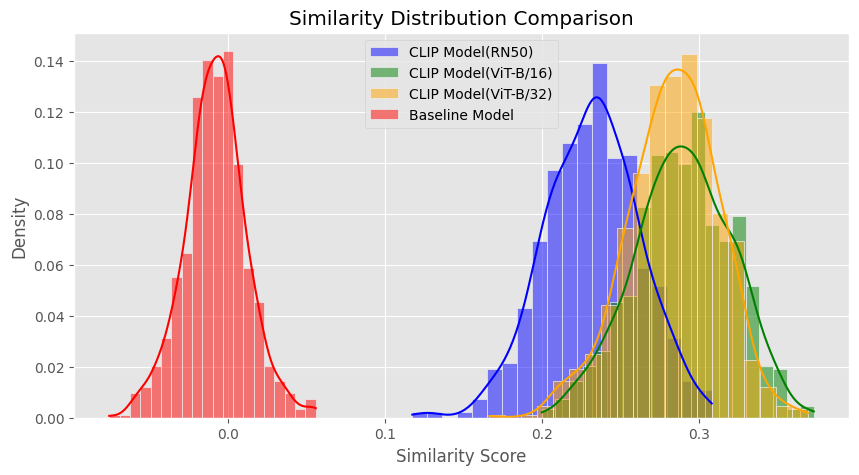

In [14]:
# similaritiesot histogram or density curve
# 创建一个画布
plt.figure(figsize=(10, 5))

# 绘制 CLIP 模型的相似度分布
sns.histplot(similarities_RN50, bins=20, kde=True, color='blue',stat='probability', label='CLIP Model(RN50)')
sns.histplot(similarities_ViT_B16, bins=20, kde=True, color='green',stat='probability', label='CLIP Model(ViT-B/16)')
sns.histplot(similarities_ViT_B32, bins=20, kde=True, color='orange',stat='probability', label='CLIP Model(ViT-B/32)')
sns.histplot(similarities_bl, bins=20, kde=True, color='red',stat='probability', label='Baseline Model')



plt.title('Similarity Distribution Comparison')
plt.xlabel('Similarity Score')
plt.ylabel('Density')

plt.legend();

plt.savefig('output/histplot.svg')

### Task 2. Text-to-Image Retrieval
---

- 每次检索，topK包含正确的都给该模型加一分

- 调整topK的个数(K = 5)

In [15]:
K = 5

#### clip

In [16]:
def retrieve_images_clip(query, k,VISUAL_BACKBONE):
    model_clip, preprocess_clip = clip.load(name=VISUAL_BACKBONE, device=device, download_root='/shareddata/clip/')
    model_clip.to(device);
    
    with torch.no_grad():
        query_tokens = clip.tokenize(query).to(device)
        query_features = model_clip.encode_text(query_tokens)
        query_features /= query_features.norm(dim=-1,keepdim=True)
        
        similarities = []

        for image,_ in dataloader_clip:
            image = image.to(device)
            image_features = model_clip.encode_image(image)
            
            image_features /= image_features.norm(dim=-1,keepdim=True)
            
            logits = image_features @ query_features.t()
            
            similarities.extend(logits.squeeze().tolist())
    
        # Retrieve top-k images based on similarity scores
        top_indices = np.argsort(similarities)[-k:]

        return top_indices,similarities

import textwrap

def plot_topK(top_indices,similarities):   
    top_images = [loaded_data[i][0] for i in top_indices]
    top_text = [loaded_data[i][1] for i in top_indices]

    fig = plt.figure(figsize=(15,4))
    plt.suptitle(f"Text-to-Image Retrieval for query:'{query}'",fontsize=16)
    
    for i in range(len(top_indices)):
        plt.subplot(1, len(top_indices), i + 1)
        plt.imshow(top_images[i])
        plt.title(f"Similarity: {similarities[top_indices[i]]:.2f}")
        plt.axis("off")
     # Wrap the text and add it below the image
        wrapped_text = textwrap.fill(top_text[i], width=26)  # Adjust width as needed

        plt.text(0, -0.2, wrapped_text, ha='left', va='center', transform=plt.gca().transAxes)
    
    plt.show()
    return fig

def test_clip(VISUAL_BACKBONE):  # RN50, ViT-B/32, ViT-B/16

    score = 0
    for idx, (_, text) in tqdm(enumerate(dataset_clip)):
        top_indices,_ = retrieve_images_clip(text,K,VISUAL_BACKBONE)
        if idx in top_indices:
            score = score + 1
    return score

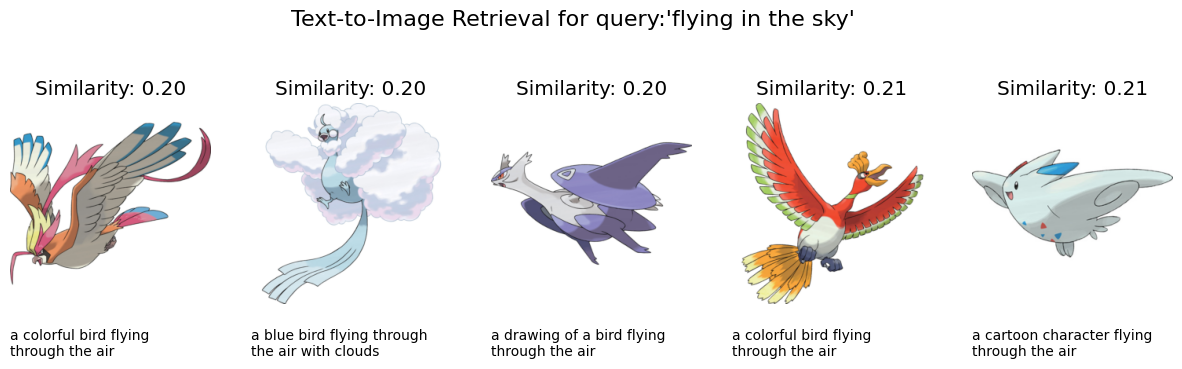

In [17]:
# Example usage
query = "flying in the sky"
topK_indices,similarities = retrieve_images_clip(query, K,'RN50')

fig_clip = plot_topK(topK_indices,similarities)
fig_clip.savefig('output/query_clip.svg')

In [18]:
score_clip_RN50 = test_clip('RN50')
score_clip_ViT_B32 = test_clip('ViT-B/32')
score_clip_ViT_B16 = test_clip('ViT-B/16')

190it [14:56,  4.72s/it]


KeyboardInterrupt: 

#### baseline model

In [ ]:
def retrieve_images_bl(query, k=5):
    with torch.no_grad():
#         query_tokens = clip.tokenize(query).to(device)
        query_features = encode_text_bl(query)
        query_features /= query_features.norm(dim=-1,keepdim=True)
        
        similarities = []

        for image,_ in dataloader_clip:
            image = image.to(device)
            image_features = encode_image_bl(image)
            
            image_features /= image_features.norm(dim=-1,keepdim=True)
            
            logits = image_features @ query_features.t()
            
            similarities.extend(logits.squeeze().tolist())
    
        # Retrieve top-k images based on similarity scores
        top_indices = np.argsort(similarities)[-k:]

        return top_indices,similarities

def test_bl():
    score = 0
    for idx, (_, text) in tqdm(enumerate(dataset_bl)):
        top_indices,_ = retrieve_images_bl(text,K)
        if idx in top_indices:
            score = score + 1
    return score

In [ ]:
# Example usage
query = "flying in the sky"
topK_indices,similarities = retrieve_images_bl(query, k=K)

fig_bl= plot_topK(topK_indices,similarities)
fig_bl.savefig('output/query_bl.svg')

In [ ]:
score_bl = test_bl()

#### plot

In [ ]:
# Create a DataFrame
data = {'Model': ['RN50', 'ViT-B/32', 'ViT-B/16', 'Baseline'],
        'Score': [score_clip_RN50, score_clip_ViT_B32, score_clip_ViT_B16, score_bl]}

df = pd.DataFrame(data).set_index('Model')
df.tocsv("score.csv")

In [ ]:
sns.lineplot(df)